In [1]:
#Loading relevant modules 
import pandas as pd 
import numpy as np
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import feature_selection#, metrics
from sklearn.feature_selection import RFE 
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Initial DataFrame shape (101766, 50) 
 
Dropping column repaglinide
Dropping column nateglinide
Dropping column chlorpropamide
Dropping column acetohexamide
Dropping column tolbutamide
Dropping column acarbose
Dropping column miglitol
Dropping column troglitazone
Dropping column tolazamide
Dropping column examide
Dropping column citoglipton
Dropping column glyburide-metformin
Dropping column glipizide-metformin
Dropping column glimepiride-pioglitazone
Dropping column metformin-rosiglitazone
Dropping column metformin-pioglitazone


Numerical columns are: ['patient_nbr', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'] 

Categorical columns are: ['race', 'gender', 'age', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insul

/home/solomon/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


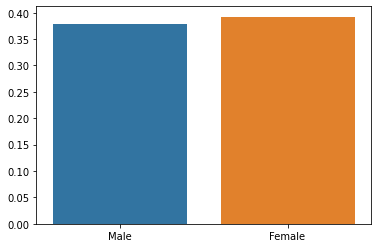

/home/solomon/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


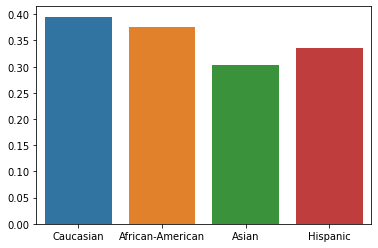

/home/solomon/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


2168 circulatory
949 respiratory
533 gastrointestinal_disease
504 genitourinary
545 diabetes_mellitus
392 musculoskeletal/connective
412 injury/poisoning
210 neoplasms
836 other


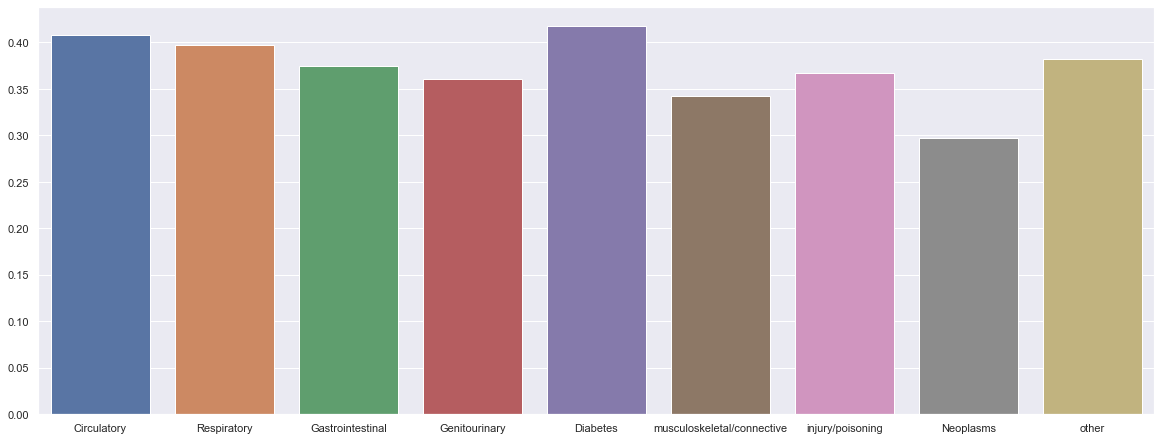

1949 circulatory
838 respiratory
468 gastrointestinal_disease
409 genitourinary
1274 diabetes_mellitus
316 musculoskeletal/connective
370 injury/poisoning
198 neoplasms
727 other
circulatory_disease           4795
diabetes_mellitus             3548
respiratory_disease           2067
other                         2006
gastrointestinal_disease      1331
genitourinary                 1200
injury/poisoning               981
musculoskeletal/connective     962
neoplasms                      649
Name: diag_2, dtype: int64


/home/solomon/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


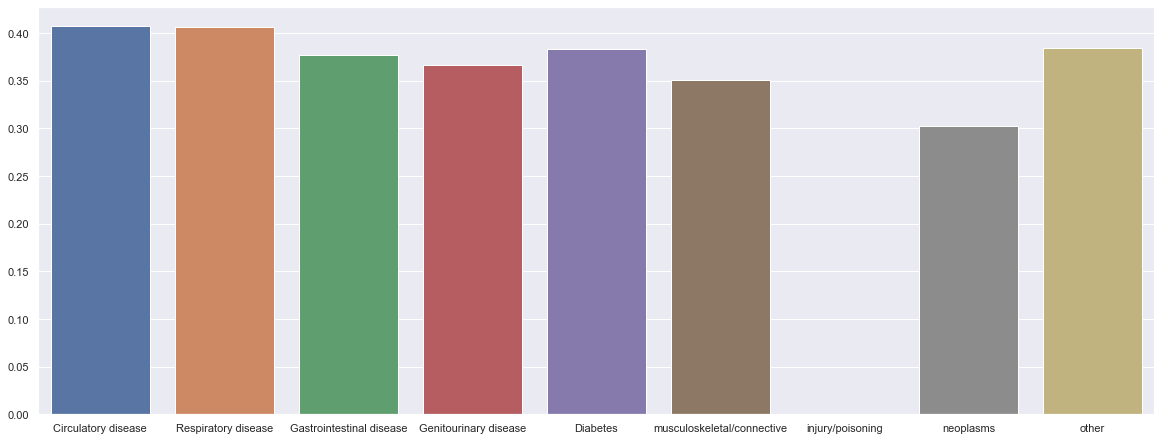

Model score:
  0.5998531571218796
Coefficients: 
num_medications 1.2956109093991838e-16
number_outpatient 8.347476796637085e-18
number_emergency 1.4486433380541525e-17
time_in_hospital 2.36086676152716e-17
number_inpatient 3.03869109984471e-17
age -4.561781776730897e-16
num_lab_procedures -1.237340694894104e-15
number_diagnoses 2.425703868210236e-17
num_procedures 5.510357905478781e-17
encounter_id -2.247263330507617e-09
Score against training data:  0.5974534769833496
Score against test data:  0.6070381231671554
Accuracy for the training set:  0.5974534769833496
Accuracy for the test set:  0.6070381231671554
True Positives:  0
False Positives:  0
True Negatives:  207
False Negatives:  134
Accuracy score =  0.6070381231671554
[[207   0]
 [134   0]]


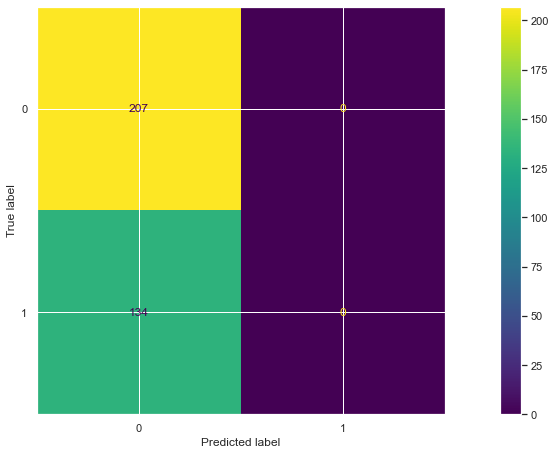

Accuracy:  0.6070381231671554
Precision:  0.0
Recall:  0.0
F1_score:  0.0
Cross validation mean score:  0.599851863822452
Model score:
  0.6541850220264317
Coefficients: 
num_medications 0.01530471887826614
number_outpatient 0.03211658849676795
number_emergency 0.3632832468758007
time_in_hospital 0.01966246393950501
number_inpatient 0.5403990095023968
age 0.002867040998031755
num_lab_procedures -0.012630989849819804
number_diagnoses 0.10393096264999642
num_procedures 0.12719200015618068


/home/solomon/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/solomon/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/solomon/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Score against training data:  0.6464250734573947
Score against test data:  0.6656891495601173
Accuracy for the training set:  0.6464250734573947
Accuracy for the test set:  0.6656891495601173
True Positives:  44
False Positives:  21
True Negatives:  183
False Negatives:  93
Accuracy score =  0.6656891495601173
[[183  21]
 [ 93  44]]


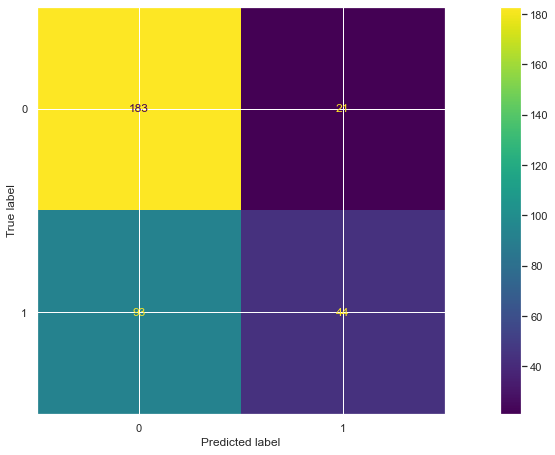

Accuracy:  0.6656891495601173
Precision:  0.32116788321167883
Recall:  0.676923076923077
F1_score:  0.4356435643564356


/home/solomon/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/solomon/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Cross validation mean score:  0.6453700711053653


/home/solomon/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyError: 1

In [3]:

#Importing the data 
df = pd.read_csv("diabetic_data.csv")


#The shape of the dataframe 
print(f"Initial DataFrame shape {df.shape} \n ") 

#Replace all missing values
df.replace('?',np.nan,inplace=True) #Replace ? with NaN 
df.replace(r'^\s*$', np.nan, regex=True, inplace=True) #Replace empty space with NaN

min50= float(0.5*(df.shape[0]+1)) #create object with value of 50% row total
df= df.dropna(axis=1,thresh=min50) #drop columns with values missing from 50% of rows 
df.dropna(axis=0,how='any') #drop any rows with missing values 

#drop columns with 95% same values 
col_heads=df.columns
df['age'].value_counts(dropna=False) #returns each value with list of counts 
min95=float(0.95*(df.shape[0]+1)) #determine 95% of values 
for column in col_heads: #for each column in col_heads 
    mylist= df[column].value_counts(dropna=False) #make a list of counts for each value found in the column
    for x in mylist: #for each value (count no. of each value in col)
        if x >= min95: #if the value is present in 95% of rows 
            df.drop(axis=1,columns=column,inplace=True)
            statement= 'dropping column: {}'.format(column)
            print(f"Dropping column {column}")

print("\n")

#Drop rows with missing values 
df.dropna(how='any', inplace=True) 

#Shape of dataframe after column removal 
#print(df.shape)

#Transforming the age column to the middle value
def age_midpoint(df):
    f = df['age'].str.split(pat='-')
    ls = []
    for i in f:
        x = i[0][1]
        d = str(x[0]) + str(5)
        ls.append(d)
    n = df.columns[5]
    df.drop(n, axis = 1, inplace = True)
    df[n] = ls
    df['age'] = df[n]
    return df['age']

df['age'] = age_midpoint(df)


#Replacing missing values in columns diag_1/2/3 
df["diag_1"].fillna(0, inplace=True)
df["diag_2"].fillna(0, inplace=True)
df["diag_3"].fillna(0, inplace=True)

#List of numerical and categorical features  
col_heads=df.columns
catlist= df.select_dtypes(object).columns.values.tolist()
numlist= df.select_dtypes(np.number).columns.values.tolist()

for col in numlist:
    if col[-2:]=='id':
        numlist.remove(col)
        catlist.append(col)

print(f'Numerical columns are: {numlist} \n')  

print(f'Categorical columns are: {catlist} \n')

 

def identify_outlier(df):
    temp = np.zeros(df.shape[0])
    for col in df.columns:
        if df[col].dtype == int or df[col].dtype == float: #and not (('encounter_id') or ('patient_nbr')):
            if df[col] is not df['encounter_id'] and (df[col] is not df['patient_nbr']):
                for i, x in enumerate(df[col]):
                    mu = df[col].mean()
                    dist_from_mean = abs(x - mu)
                    dev = df[col].std()
                    y= 3*dev
                    if (dist_from_mean > y): #if larger than 3 std devs away from mu, mark as outlier
                        temp[i] = 1

    df['outliers'] = temp
    return df

df = identify_outlier(df)

# Removing outliers
def removed_outliers(df, outliers=True):
    if outliers:
        df = identify_outlier(df)  # mark outliers
        df = df[df['outliers'] == 0].copy() # filter for outliers
        df.drop('outliers', axis = 1, inplace = True)
    return df
df = removed_outliers(df, outliers=True)
   

#Removing duplicates in the column patient_nbr 
df = df.drop_duplicates(subset='patient_nbr',keep='first')

print(f"Final DataFrame shape {df.shape}")


'''Data Exploration'''

df['readmitted'] = df['readmitted'].replace({'>30':'1', '<30':'1', 'NO': '0'})
dum_cols=['gender', 'race']
dummies=pd.get_dummies(df, columns=dum_cols)
df = pd.concat([df, dummies], axis = 1)
df = df.loc[:,~df.columns.duplicated()]
df.shape

ls = list(df['diag_1'])
def diag_1(df):
    for i, x in enumerate(df['diag_1']):
        v = str(x)
        if v[0].isalpha():
            ls[i] = v.replace(v,'other')
        elif v[0].isdigit():
            s = float(v)
            if (s > 390 and s < 460) or s == 785:#s in range(390, 460):
                p = str(s)
                ls[i] = p.replace(p,'circulatory_disease')
            elif s > 249.99 and s < 251:
                p = str(s)
                ls[i] = p.replace(p,'diabetes_mellitus')
            elif (s > 459 and s < 520) or s == 786:
                p = str(s)
                ls[i] = p.replace(p,'respiratory_disease')
            elif (s > 519 and s < 580) or s == 787:
                p = str(s)
                ls[i] = p.replace(p,'gastrointestinal_disease')
            elif (s > 799 and s < 1000):
                p = str(s)
                ls[i] = p.replace(p,'injury/poisoning')
            elif (s > 709 and s < 740):
                p = str(s)
                ls[i] = p.replace(p,'musculoskeletal/connective')
            elif (s > 579 and s < 740):
                p = str(s)
                ls[i] = p.replace(p,'genitourinary')
            elif (s > 139 and s < 240):
                p = str(s)
                ls[i] = p.replace(p,'neoplasms')
            else:
                p = str(s)
                ls[i] = p.replace(p,'other')                

    df['diag_1'] = ls
    return df['diag_1']

df['diag_1'] = diag_1(df)

ls1 = list(df['diag_2'])
def diag_2(df):
    for i, x in enumerate(df['diag_2']):
        v = str(x)
        if v[0].isalpha():
            ls1[i] = v.replace(v,'other')
        elif v[0].isdigit():
            s = float(v)
            if (s > 390 and s < 460) or s == 785:#s in range(390, 460):
                p = str(s)
                ls1[i] = p.replace(p,'circulatory_disease')
            elif s > 249.99 and s < 251:
                p = str(s)
                ls[i] = p.replace(p,'diabetes_mellitus')
            elif (s > 459 and s < 520) or s == 786:
                p = str(s)
                ls1[i] = p.replace(p,'respiratory_disease')
            elif (s > 519 and s < 580) or s == 787:
                p = str(s)
                ls1[i] = p.replace(p,'gastrointestinal_disease')
            elif (s > 799 and s < 1000):
                p = str(s)
                ls1[i] = p.replace(p,'injury/poisoning')
            elif (s > 709 and s < 740):
                p = str(s)
                ls1[i] = p.replace(p,'musculoskeletal/connective')
            elif (s > 579 and s < 740):
                p = str(s)
                ls1[i] = p.replace(p,'genitourinary')
            elif (s > 139 and s < 240):
                p = str(s)
                ls1[i] = p.replace(p,'neoplasms')
            else:
                p = str(s)
                ls1[i] = p.replace(p,'other')                

    df['diag_2'] = ls
    return df['diag_2']

df['diag_2'] = diag_2(df)

ls2 = list(df['diag_3'])
def diag_3(df):
    for i, x in enumerate(df['diag_3']):
        v = str(x)
        if v[0].isalpha():
            ls1[i] = v.replace(v,'other')
        elif v[0].isdigit():
            s = float(v)
            if (s > 390 and s < 460) or s == 785:#s in range(390, 460):
                p = str(s)
                ls2[i] = p.replace(p,'circulatory_disease')
            elif s > 249.99 and s < 251:
                p = str(s)
                ls2[i] = p.replace(p,'diabetes_mellitus')
            elif (s > 459 and s < 520) or s == 786:
                p = str(s)
                ls2[i] = p.replace(p,'respiratory_disease')
            elif (s > 519 and s < 580) or s == 787:
                p = str(s)
                ls2[i] = p.replace(p,'gastrointestinal_disease')
            elif (s > 799 and s < 1000):
                p = str(s)
                ls2[i] = p.replace(p,'injury/poisoning')
            elif (s > 709 and s < 740):
                p = str(s)
                ls2[i] = p.replace(p,'musculoskeletal/connective')
            elif (s > 579 and s < 740):
                p = str(s)
                ls2[i] = p.replace(p,'genitourinary')
            elif (s > 139 and s < 240):
                p = str(s)
                ls2[i] = p.replace(p,'neoplasms')
            else:
                p = str(s)
                ls2[i] = p.replace(p,'other')                

    df['diag_3'] = ls
    return df['diag_3']
df['diag_3'] = diag_3(df)

import matplotlib.pyplot as plt
import seaborn as sns

def readmission_hists(df, plot_cols, grid_col):
    for col in plot_cols:
        #if (col != 'encounter_id' and col != 'patient_nbr'):
        if col == 'age':
            g = sns.FacetGrid(df, col=grid_col, margin_titles=True)
            g.map(plt.hist, col)
            plt.show()
readmission_hists (df, df.select_dtypes(include=[np.number]).columns, "readmitted")

ls3=[]
for i, j in zip(list(df['readmitted']), list(df['gender_Male'])):
    if int(i) == int(j):
        ls3.append(i)
#print(len(ls3))
print(ls3.count('1'), 'male') # = num of men readmitted
#print(ls3.count('0'))

ls4=[]
for i, j in zip(list(df['readmitted']), list(df['gender_Female'])):
    if int(i) == int(j):
        ls4.append(i)
print(ls4.count('1'), 'female')

ls5=[]
for i, j in zip(list(df['readmitted']), list(df['race_Caucasian'])):
    if int(i) == int(j):
        ls5.append(i)
print(ls5.count('1'), 'cauc')

ls6=[]
for i, j in zip(list(df['readmitted']), list(df['race_AfricanAmerican'])):
    if int(i) == int(j):
        ls6.append(i)
print(ls6.count('1'), 'african-americ')

ls7=[]
for i, j in zip(list(df['readmitted']), list(df['race_Asian'])):
    if int(i) == int(j):
        ls7.append(i)
print(ls7.count('1'), 'asian')

ls8=[]
for i, j in zip(list(df['readmitted']), list(df['race_Hispanic'])):
    if int(i) == int(j):
        ls8.append(i)
print(ls8.count('1'), 'hispanic')

print(df['gender_Male'].value_counts())
print(df['gender_Female'].value_counts())
print(df['race_Caucasian'].value_counts())
print(df['race_AfricanAmerican'].value_counts())
print(df['race_Asian'].value_counts())
print(df['race_Hispanic'].value_counts())

#normalised --> (total of group that were readmitted)/(total of group)
x = ['Male', 'Female']
y = [11410 / 30191, 13450 / 34274]
sns.barplot(x, y)
plt.show()

x = ['Caucasian', 'African-American','Asian','Hispanic']
y = [18997/48048, 4397/11718, 140/461, 449/1341]

sns.barplot(x, y)
plt.show()

ls9=[]
for i, j in zip(list(df['readmitted']), list(df['diag_1'])):
    if i == '1' and j == 'circulatory_disease':
        ls9.append(1)
print(ls9.count(1), 'circulatory')

ls9=[]
for i, j in zip(list(df['readmitted']), list(df['diag_1'])):
    if i == '1' and j == 'respiratory_disease':
        ls9.append(1)
print(ls9.count(1), 'respiratory')

ls9=[]
for i, j in zip(list(df['readmitted']), list(df['diag_1'])):
    if i == '1' and j == 'gastrointestinal_disease':
        ls9.append(1)
print(ls9.count(1), 'gastrointestinal_disease')

ls9=[]
for i, j in zip(list(df['readmitted']), list(df['diag_1'])):
    if i == '1' and j == 'genitourinary':
        ls9.append(1)
print(ls9.count(1), 'genitourinary')

ls9=[]
for i, j in zip(list(df['readmitted']), list(df['diag_1'])):
    if i == '1' and j == 'diabetes_mellitus':
        ls9.append(1)
print(ls9.count(1), 'diabetes_mellitus')

ls9=[]
for i, j in zip(list(df['readmitted']), list(df['diag_1'])):
    if i == '1' and j == 'musculoskeletal/connective':
        ls9.append(1)
print(ls9.count(1), 'musculoskeletal/connective')

ls9=[]
for i, j in zip(list(df['readmitted']), list(df['diag_1'])):
    if i == '1' and j == 'injury/poisoning':
        ls9.append(1)
print(ls9.count(1), 'injury/poisoning')
        
ls9=[]
for i, j in zip(list(df['readmitted']), list(df['diag_1'])):
    if i == '1' and j == 'neoplasms':
        ls9.append(1)
print(ls9.count(1), 'neoplasms')

ls9=[]
for i, j in zip(list(df['readmitted']), list(df['diag_1'])):
    if i == '1' and j == 'other':
        ls9.append(1)
print(ls9.count(1), 'other')


#df['readmitted']

df['diag_1'].value_counts()

import seaborn as sns
#from matplotlib import pyplot
x = ['Circulatory', 'Respiratory', 'Gastrointestinal','Genitourinary','Diabetes',
    'musculoskeletal/connective', 'injury/poisoning', 'Neoplasms', 'other']
y = [8025/19652, 3581/9006, 2274/6077, 1926/5345, 1959/4690, 1319/3847, 1603/4361, 755/2544, 3418/8946]

sns.set(rc={'figure.figsize':(20,7.5)})
sns.barplot(x, y)#, height=5)
plt.show()

ls11=[]
for i, j in zip(list(df['readmitted']), list(df['diag_2'])):
    if i == '1' and j == 'circulatory_disease':
        ls11.append(1)
print(ls11.count(1), 'circulatory')

ls11=[]
for i, j in zip(list(df['readmitted']), list(df['diag_2'])):
    if i == '1' and j == 'respiratory_disease':
        ls11.append(1)
print(ls11.count(1), 'respiratory')

ls11=[]
for i, j in zip(list(df['readmitted']), list(df['diag_2'])):
    if i == '1' and j == 'gastrointestinal_disease':
        ls11.append(1)
print(ls11.count(1), 'gastrointestinal_disease')

ls11=[]
for i, j in zip(list(df['readmitted']), list(df['diag_2'])):
    if i == '1' and j == 'genitourinary':
        ls11.append(1)
print(ls11.count(1), 'genitourinary')

ls11=[]
for i, j in zip(list(df['readmitted']), list(df['diag_2'])):
    if i == '1' and j == 'diabetes_mellitus':
        ls11.append(1)
print(ls11.count(1), 'diabetes_mellitus')

ls11=[]
for i, j in zip(list(df['readmitted']), list(df['diag_2'])):
    if i == '1' and j == 'musculoskeletal/connective':
        ls11.append(1)
print(ls11.count(1), 'musculoskeletal/connective')

ls11=[]
for i, j in zip(list(df['readmitted']), list(df['diag_2'])):
    if i == '1' and j == 'injury/poisoning':
        ls11.append(1)
print(ls11.count(1), 'injury/poisoning')
        
ls11=[]
for i, j in zip(list(df['readmitted']), list(df['diag_2'])):
    if i == '1' and j == 'neoplasms':
        ls11.append(1)
print(ls11.count(1), 'neoplasms')

ls11=[]
for i, j in zip(list(df['readmitted']), list(df['diag_2'])):
    if i == '1' and j == 'other':
        ls11.append(1)
print(ls11.count(1), 'other')


#df['readmitted']

print(df['diag_2'].value_counts())

#DIAG 2 & 3 (same num of diagnoses)
x = ['Circulatory disease', 'Respiratory disease', 'Gastrointestinal disease','Genitourinary disease','Diabetes',
    'musculoskeletal/connective', 'injury/poisoning', 'neoplasms', 'other']
y = [7012/17205, 3047/7504, 1937/5137, 1561/4254, 5247/13691, 1031/2941, 0, 679/2241, 2928/7625]

sns.set(rc={'figure.figsize':(20,7.5)})
sns.barplot(x, y)
plt.show()

#Model 1

from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import feature_selection#, metrics
from sklearn.feature_selection import RFE 
from sklearn.svm import SVR
#df = df.loc[:,~df.columns.duplicated()] #remove duplicated 'readmitted' col
df1 = df[['encounter_id','num_medications', 'number_outpatient', 'number_emergency', 'time_in_hospital', 
'number_inpatient', 'age', 'num_lab_procedures', 'number_diagnoses', 
'num_procedures','diag_1', 'diag_2', 'diag_3', 'readmitted']]
df1 = df1.drop(df1.loc[df1['diag_1']!='diabetes_mellitus'].index)#, inplace=False)
df1 = df1.drop(df1.loc[df1['diag_2']!='diabetes_mellitus'].index)#, inplace=False)
df1 = df1.drop(df1.loc[df1['diag_3']!='diabetes_mellitus'].index)#, inplace=False)

model1 = linear_model.LogisticRegression()
cols = ['num_medications', 'number_outpatient', 'number_emergency', 'time_in_hospital', 
'number_inpatient', 'age', 'num_lab_procedures', 'number_diagnoses', 'num_procedures', 'encounter_id']

X = df1[cols]
Y = df1['readmitted']
model1.fit(X, Y)

print('Model score:\n ', model1.score(X,Y))
print('Coefficients: ')
for feat, coef in zip(cols, model1.coef_[0]):
    print(feat, coef)

X_train, X_test, Y_train, Y_test = train_test_split(
X, Y, test_size=0.25)
model2 = linear_model.LogisticRegression()
model2.fit(X_train, Y_train)
print("Score against training data: ",model2.score(X_train, Y_train))
print("Score against test data: ", model2.score(X_test, Y_test))
#scores = cross_val_score(linear_model.LogisticRegression(), X, Y, scoring='accuracy', cv=10)
#print("Cross validation mean scores: {}".format(scores.mean()))

#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

df1['readmitted'] = df1['readmitted'].replace({1:'1', 1:'1', 0: '0'})
#df1['readmitted'] = df1['readmitted'].replace({'1':1, '0':0})

#print(df1)
#print(df['readmitted'])#.dtype)
pred_test = model2.predict(X_test)
pred_train = model2.predict(X_train)

## Acuracy score for the training data
accuracy_train = accuracy_score(pred_train, Y_train)
print('Accuracy for the training set: ', accuracy_train)
## Acuracy score for the test data
accuracy_test = accuracy_score(pred_test, Y_test)
print('Accuracy for the test set: ', accuracy_test)


# confusion matrix for the test data
pred = pred_test
cm = confusion_matrix(Y_test, pred)

TN, FP, FN, TP = confusion_matrix(Y_test, pred_test).ravel()

print('True Positives: ', TP)
print('False Positives: ', FP)
print('True Negatives: ', TN)
print('False Negatives: ', FN)

accuracy = (TP+TN) /(TP+FP+TN+FN)

print('Accuracy score = ', accuracy)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model2.classes_)
disp.plot()
plt.show()

# Calculate Accuracy, Precision and Recall Metrics for the test data
accuracy = accuracy_score(pred, Y_test)
print('Accuracy: ', accuracy)
precision = precision_score(pred, Y_test,pos_label = '1')
print('Precision: ', precision)
recall = recall_score(pred, Y_test,pos_label = '1')
print('Recall: ', recall)
f1score = f1_score(pred, Y_test,pos_label = '1')

print('F1_score: ', f1score)
plt.show()

   #CROSS VALIDATION
scores = cross_val_score(linear_model.LogisticRegression(), X, Y, scoring='accuracy')
print('Cross validation mean score: ', scores.mean())

#Improved model
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import feature_selection#, metrics
from sklearn.feature_selection import RFE 
from sklearn.svm import SVR
#df = df.loc[:,~df.columns.duplicated()] #remove duplicated 'readmitted' col
df1 = df[['num_medications', 'number_outpatient', 'number_emergency', 'time_in_hospital', 
'number_inpatient', 'age', 'num_lab_procedures', 'number_diagnoses', 
'num_procedures','diag_1', 'diag_2', 'diag_3', 'readmitted']]
df1 = df1.drop(df1.loc[df1['diag_1']!='diabetes_mellitus'].index)#, inplace=False)
df1 = df1.drop(df1.loc[df1['diag_2']!='diabetes_mellitus'].index)#, inplace=False)
df1 = df1.drop(df1.loc[df1['diag_3']!='diabetes_mellitus'].index)#, inplace=False)

model1 = linear_model.LogisticRegression()
cols = ['num_medications', 'number_outpatient', 'number_emergency', 'time_in_hospital', 
'number_inpatient', 'age', 'num_lab_procedures', 'number_diagnoses', 'num_procedures']

X = df1[cols]
Y = df1['readmitted']
model1.fit(X, Y)

print('Model score:\n ', model1.score(X,Y))
print('Coefficients: ')
for feat, coef in zip(cols, model1.coef_[0]):
    print(feat, coef)

X_train, X_test, Y_train, Y_test = train_test_split(
X, Y, test_size=0.25)
model2 = linear_model.LogisticRegression()
model2.fit(X_train, Y_train)
print("Score against training data: ",model2.score(X_train, Y_train))
print("Score against test data: ", model2.score(X_test, Y_test))
#scores = cross_val_score(linear_model.LogisticRegression(), X, Y, scoring='accuracy', cv=10)
#print("Cross validation mean scores: {}".format(scores.mean()))

#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

df1['readmitted'] = df1['readmitted'].replace({1:'1', 1:'1', 0: '0'})
#df1['readmitted'] = df1['readmitted'].replace({'1':1, '0':0})

#print(df1)
#print(df['readmitted'])#.dtype)
pred_test = model2.predict(X_test)
pred_train = model2.predict(X_train)

## Acuracy score for the training data
accuracy_train = accuracy_score(pred_train, Y_train)
print('Accuracy for the training set: ', accuracy_train)
## Acuracy score for the test data
accuracy_test = accuracy_score(pred_test, Y_test)
print('Accuracy for the test set: ', accuracy_test)


# confusion matrix for the test data
pred = pred_test
cm = confusion_matrix(Y_test, pred)

TN, FP, FN, TP = confusion_matrix(Y_test, pred_test).ravel()

print('True Positives: ', TP)
print('False Positives: ', FP)
print('True Negatives: ', TN)
print('False Negatives: ', FN)

accuracy = (TP+TN) /(TP+FP+TN+FN)

print('Accuracy score = ', accuracy)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model2.classes_)
disp.plot()
plt.show()

# Calculate Accuracy, Precision and Recall Metrics for the test data
accuracy = accuracy_score(pred, Y_test)
print('Accuracy: ', accuracy)
precision = precision_score(pred, Y_test,pos_label = '1')
print('Precision: ', precision)
recall = recall_score(pred, Y_test,pos_label = '1')
print('Recall: ', recall)
f1score = f1_score(pred, Y_test,pos_label = '1')

print('F1_score: ', f1score)
plt.show()

   #CROSS VALIDATION
scores = cross_val_score(linear_model.LogisticRegression(), X, Y, scoring='accuracy')
print('Cross validation mean score: ', scores.mean())


'''K Means Clustering'''
#create object w/ numerical column list 
col_heads=list(df.columns)
catlist= df.select_dtypes(object).columns.values.tolist()
numlist= df.select_dtypes(np.number).columns.values.tolist()

for col in numlist:
    if col != 'encounter_id'and col[-2:] =='id':
        numlist.remove(col)
        catlist.append(col)
numlist.remove('patient_nbr')

#min/max normalisations and dropping non-continuous variables from data frame 
df_norm=df.copy()
for x in numlist: 
    if x in df.columns:
        df_norm[x]= (df[x]-df[x].min()) / (df[x].max()-df[x].min())
df_norm.loc[1]

#remove categorical values from df, and also patient numbers/ids 
for x in catlist:
    if x in df_norm.columns:
        df_norm.drop(labels=x,axis=1, inplace=True)
df_norm.drop(labels=['patient_nbr','admission_source_id'],axis=1,inplace=True)

### model building 
#call algorithm with 6 clusters 
model = KMeans(n_clusters=6)
model.fit(df_norm)
print('cost=',model.inertia_) # J score (lower = better)
#j score = sum of square distances between each point + its centroid 
print(model.labels_) #labels denoting clusters for each row of df 

#add cluster assignments to df with below script 
labels=model.labels_ #take titles of each labelled datapoint 
md=pd.Series(labels) #make a series out of each datapoint 
df['clust']=md
df_norm['clust']=md
# means of data points for each cluster 
df_norm.groupby('clust').mean()
# see the mean of each column for each cluster 

#make elbow plot - for determining / supporting K value
#identify 'joint' in elbow that informs on optimal cluster no. 
def elbow(data):
    print("\nPlotting elbow method...")
    sse = {}
    for k in range(2, 20, 2):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
        print(k, kmeans.inertia_)
        sse[k] = kmeans.inertia_  
        # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), linewidth=4)
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost")
    plt.show()
    print("DONE")
elbow(df_norm) # use the above function to print an elbow plot for our data 

##PCA 
######## 2D plot of the clusters
##create PCA model 
pca_data = PCA(n_components=2).fit(df_norm)
pca_2d = pca_data.transform(df_norm)

#create new column for readmission data to overlay on scatterplot 
df.readmitted=pd.Categorical(df.readmitted) #create category of readmittance to colour the plot
df['code'] = df.readmitted.cat.codes #0 = <30, 1 = >30, 2= NO

#plot scatterplot of clusters using PCAs 
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=labels) #change c= to labels/df['code'] for different colours of clusters 
#plt.legend([0,1,2],['Before 30d', 'After 30d','Not readmitted']) #0 = <30, 1 = >30, 2= NO
plt.title('Patient clusters / all continuous variables / k = 6')
plt.show()

# second graph w/ readmitted status overlayed
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=df['code']) #change c= to labels/df['code'] for different colours of clusters 
#plt.legend([0,1,2],['Before 30d', 'After 30d','Not readmitted']) #0 = <30, 1 = >30, 2= NO
plt.title('Patient clusters / all continuous variables / k = 6')
plt.show()

##IMPROVEMENTS TO THE K-MEANS MODEL (using PCA)
df_norm.drop(labels=['encounter_id'],axis=1,inplace=True) #DROP THIS - explains vast majority of variance 
pca=PCA()
pca.fit(df_norm)

pca.explained_variance_ratio_ #show the amount of variance each column explains

#cumulative variance plot to determine no. of features to include in PCA 
##CUMULATIVE VARIANCE PLOT 
plt.plot(range(1,10),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.title('explained variance by components')
plt.xlabel('no. of components')
plt.ylabel('cumulative explained variance')

pca2 = PCA(n_components=5) #build new PCA model 
pca2.fit(df_norm) #fit our data to PCA model 
scores_pca2=pca2.transform(df_norm) #list scores from model 

#calling values from new model 
newmodel=KMeans(n_clusters=8,init='k-means++',random_state=50) #create new KMeans model for PCA data 
newmodel.fit(scores_pca2)

j=newmodel.inertia_ #get j-score for new model 